In [1]:
""" This file has operations for image processing """

import numpy as np
import gzip
from enums import Metrics
from io import BytesIO
from PIL import Image
from skimage import img_as_ubyte, img_as_float
from skimage.measure import compare_psnr, compare_ssim
from skimage.util import view_as_blocks
from bitstring import Bits
from pathlib import PosixPath
from msssim import compare_msssim
import pandas as pd
import os
from pathlib import Path
import warnings

from enums import ImgData
import matplotlib
import matplotlib.pyplot as plt

class ImgProc:
    """ Static class that has methods to make basic operations on images """
    @staticmethod
    def pad_img(img, patch_size):
        """ Method that receives an image and a size for the patches. The method
            pad the image so that they can be cropped later
        """
        orig_shape = np.array(img.shape[:2])
        new_shape = patch_size * np.ceil(orig_shape / patch_size).astype(int)
        points_to_pad = new_shape - orig_shape
        pad_img = np.pad(img, [(0, points_to_pad[0]), (0, points_to_pad[1]),
                         (0, 0)], 'edge')
        return pad_img

    @staticmethod
    def is_pillow_valid_img(pathname, return_ref=True):
        """ Function that verifies if the file is a valid image considering
            the pillow library, that's used in this code. If desired, it
            returns the opened ref. The retuned reference must be closed later.
        """
        try:
            img = Image.open(pathname)
            is_valid = True
        except Exception:
            img = []
            is_valid = False

        ret = is_valid
        if return_ref:
            ret = list([ret])
            ret.append(img)
        else:
            img.close()

        return ret

    @staticmethod
    def get_img_real_ext(pathname):
        """ Function that identifies the format of the image and return it as
            a lower case string. If it's not a valid image, returns None.
        """
        valid, img = ImgProc.is_pillow_valid_img(pathname)
        if not valid:
            return None

        format = img.format.lower()
        img.close()
        return format

    @staticmethod
    def reconstruct_image(patches, width, height):
        """ Method that receives a 1D array of patches and the dimensions of
            the image and reconstruct the image based on the patches array
        """
        patch_size = patches[0].shape[0]
        colors = 1
        if len(patches[0].shape) > 2:
            colors = patches.shape[3]
        p_rows = np.ceil(height / patch_size).astype(int)
        p_columns = np.ceil(width / patch_size).astype(int)
        round_height = p_rows * patch_size
        round_width = p_columns * patch_size

        # First index changing fastest (reshape a grid of patches)
        img = patches.reshape(p_rows, p_columns, patch_size, patch_size,
                              colors)
        # Rows and columns near one another (for numpy to order them correctly)
        img = img.swapaxes(1, 2).reshape(round_height, round_width, colors)
        img = img[:height, :width]
        return img

    @staticmethod
    # TODO: use view_as_windows to implement extraction of overlapping patches
    def extract_img_patch(orig_img, patch_size):
        """ Method that receives an image and the patch size and extract
            the patches of the image.
        """
        if np.all(np.equal(orig_img.shape, patch_size)):
            return orig_img

        img = ImgProc.pad_img(orig_img, patch_size)
        color = 1
        if len(img.shape) > 2:
            color = img.shape[2]
        patches = view_as_blocks(img, (patch_size, patch_size, color))
        patches = patches.reshape(-1, patch_size, patch_size, color)
        return patches

    @staticmethod
    def conv_data_format(img, data_format):
        """ Method that receives a valid image array and a desired format to
            convert into.
        """
        if not isinstance(data_format, ImgData):
            raise ValueError("Format argument must be an " + ImgData.__name__)

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')

            if data_format == ImgData.UBYTE:
                out_img = img_as_ubyte(img)
                return out_img

            if data_format == ImgData.FLOAT:
                out_img = img_as_float(img)
                out_img = out_img.astype(np.float32)
                return out_img

        raise ValueError('Range parameter is not recognized!')

    @staticmethod
    def save_img_from_ref(img_ref, new_path, kwargs={}):
        """ Utils function to rename a image. It's useful for conversion of
            images. It's also useful as a wrapper to avoid importing the PIL in
            other files
        """
        if isinstance(img_ref, (PosixPath, str)):
            img_ref = Image.open(img_ref)
        if isinstance(img_ref, np.ndarray):
            img_ref = Image.fromarray(img_ref)

        img_ref.save(new_path, **kwargs)

    @staticmethod
    def load_image(path, data_format=None, color_mode='RGB'):
        """ This method receives an image pathname and the target colorspace.
            If the path points to a non valid image, it returns empty data.
        """
        valid, img = ImgProc.is_pillow_valid_img(path)
        if not valid:
            return []

        if color_mode:
            img = img.convert(color_mode)
        img_data = np.array(img)
        img.close()

        if data_format:
            img_data = ImgProc.conv_data_format(img_data, data_format)

        return img_data

    @staticmethod
    def calc_n_patches(info, patch_size):
        """ Calculates the number of patches images with this height and
            widht considering the padding """
        if isinstance(info, (PosixPath, str)):
            img = Image.open(info)
            width, height = img.size
        elif isinstance(info, list):
            width, height = info
        else:
            width, height = info

        line_patches = np.ceil(height / patch_size).astype(int)
        column_patches = np.ceil(width / patch_size).astype(int)
        num_of_patches = line_patches * column_patches
        return num_of_patches

    @staticmethod
    def calc_bpp_using_gzip(list_arrays, pixels_num, bpp_proxy, pos):
        """ Function that calculates the bpp considering the gzip. It receives
            a data_array representing an image.
        """
        try:
            # If the number is not already an integer, it's not been quantized
            # So it's not fair do estimate bpp using a round version
            if np.all(np.equal(np.mod(list_arrays[0], 1), 0)):
                list_arrays = list(map(lambda e: np.array(e).astype(np.int),
                                       list_arrays))

            compressed = list(map(gzip.compress, list_arrays))
            # Bits has many representations. length get the len in bits
            bpp = list(map(lambda c: Bits(c).length / pixels_num, compressed))
            bpp_proxy[pos] = list(np.cumsum(bpp))
        except Exception as e:
            print(str(e))

    @staticmethod
    def calc_metric(true_ref, test_ref, metric):
        """ Wrapper from skimage psnr and ssim comparison. """
        if isinstance(true_ref, (Path, str)):
            true_ref = Image.open(true_ref)
        if isinstance(test_ref, (Path, str)):
            test_ref = Image.open(test_ref)

        true_ref = np.array(true_ref)
        test_ref = np.array(test_ref)

        if metric == Metrics.PSNR:
            result = compare_psnr(true_ref, test_ref)
        elif metric == Metrics.SSIM:
            result = compare_ssim(true_ref, test_ref, multichannel=True)
        elif metric == Metrics.MSSSIM:
            # TODO: find official implementation that really works (skvideo
            # did not work and apparently it's not being supported anymore)
            # TODO: verify this implementation is correct. Compare with the
            # other implementations
            true_ref = np.expand_dims(
                np.expand_dims(true_ref, 0), 0).swapaxes(0, -1)
            test_ref = np.expand_dims(
                np.expand_dims(test_ref, 0), 0).swapaxes(0, -1)
            aux_result = list(map(compare_msssim, true_ref, test_ref))
            result = np.mean(aux_result)

        # Put a huge number in this case
        result = np.iinfo(np.uint8).max if result == float('inf') else result

        return result

    @staticmethod
    def save_img(img_ref, path, mode='RGB'):
        """ Method that receives a numpy array and a path. It saves an image
            through PIL
        """
        try:
            if isinstance(img_ref, (str, PosixPath)):
                img_ref = Image.open(img_ref)
            elif isinstance(img_ref, np.ndarray):
                img_ref = Image.fromarray(img_ref)

            img_ref.save(path, mode=mode)
            img_ref.close()
        except Exception as e:
            print(str(e))

    @staticmethod
    def get_size(path):
        """ Wrapper that receives a path of an image and returns its size """
        with Image.open(path) as img_ref:
            width, height = img_ref.size
        return width, height

    @staticmethod
    def save_jpeg_analysis(img_path, out_pathname):
        """ This method analysis an image with jpeg wrt to bpp and visual
            metrics. It saves a csv file with this info.
        """
        # PIL doesn't handle numpy types
        quality = list(map(int, np.arange(69, 73)))
        params = list(map(lambda q: dict(quality=q), quality))

        valid, img_ref = ImgProc.is_pillow_valid_img(img_path)
        if not valid:
            return

        pixel_num = np.prod(img_ref.size)
        img_data = np.array(img_ref)
        bpp, psnr, ssim, msssim = [], [], [], []
        for param in params:
            with BytesIO() as buffer:
                img_ref.save(buffer, 'jpeg', **param)
                codec_data = np.array(Image.open(buffer))
                codec_buffer = buffer.getvalue()
            num_bits = Bits(codec_buffer).length
            bpp.append(num_bits / pixel_num)
            psnr.append(ImgProc.calc_metric(img_data, codec_data, Metrics.PSNR))
            ssim.append(ImgProc.calc_metric(img_data, codec_data, Metrics.SSIM))
            msssim.append(ImgProc.calc_metric(img_data, codec_data,
                                              Metrics.MSSSIM))
        data = np.stack((quality, psnr, ssim, msssim, bpp), axis=1)
        df = pd.DataFrame(data, columns=['quality', 'psnr', 'ssim',
                                         'msssim', 'bpp'])
        df.set_index('quality', inplace=True)
        df.to_csv(out_pathname)

    @staticmethod
    def save_jpeg2000_kakadu(orig_pathname, output_pathname, bpp):
        """ Save a image in kakadu jpeg2000 format """
        cmd = 'kdu_compress -i \'{}\' -o \'{}\' -rate {} >/dev/null 2>&1'\
            .format(orig_pathname, output_pathname, bpp)
        if os.system(cmd):
            raise RuntimeError('Error when executing kakadu binary!')




In [4]:
my_analysis=ImgProc()
from PIL import Image
import glob


reconstruida='/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/'
original='/home/marcelo/Documentos/rnn-conv-autoencoder/datasets/'
iteracoes=16
number_img=12
msssim=np.zeros((number_img,iteracoes), dtype=np.float64)
ssim=np.zeros((number_img,iteracoes), dtype=np.float64)
psnr=np.zeros((number_img,iteracoes), dtype=np.float64)

for j in range (number_img):
    name_imgs=[]
    k=len(original)
    for filename in glob.glob(original+'*'):
        name_imgs.append(filename[k:-4])
    name_img=name_imgs[j-1]

    print(name_img) 
    original_img = original+name_img+'.png'
    print(original_img)

            
    for i in range(iteracoes):
        reconstruida_img= reconstruida+name_img+'8_iter'+str(i+1)+'.bmp'
        print(reconstruida_img)
        psnr[j][i]=my_analysis.calc_metric(original_img,reconstruida_img,Metrics.PSNR) 
        msssim[j][i]=my_analysis.calc_metric(original_img,reconstruida_img,Metrics.MSSSIM)
        ssim[j][i]=my_analysis.calc_metric(original_img,reconstruida_img,Metrics.SSIM)
        
print('PSNR:')
for y in range(0,iteracoes):
    ls=[]
    for x in range(0,12):
        ls.append(psnr[x][y])
    print(str(np.mean(ls)).replace('.',','))

        
print('SSIM:')
for y in range(iteracoes):
    ls=[]
    for x in range(0,12):
        ls.append(ssim[x][y])
    print(str(np.mean(ls)).replace('.',','))
    
print('MSSSIM:')
for y in range(iteracoes):
    ls=[]
    for x in range(0,12):
        ls.append(msssim[x][y])
    print(str(np.mean(ls)).replace('.',','))
        

nova_bridge
/home/marcelo/Documentos/rnn-conv-autoencoder/datasets/nova_bridge.png
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter1.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter2.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter3.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter4.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter5.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter6.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter7.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter8.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter9.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_bridge8_iter10.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova

/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter7.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter8.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter9.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter10.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter11.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter12.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter13.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter14.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter15.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_flower_foveon8_iter16.bmp
nova_cathedral
/home/marcelo/Documentos/rnn-conv-autoencoder/datasets/nov

/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_fireworks8_iter15.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_fireworks8_iter16.bmp
nova_big_building
/home/marcelo/Documentos/rnn-conv-autoencoder/datasets/nova_big_building.png
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_big_building8_iter1.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_big_building8_iter2.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_big_building8_iter3.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_big_building8_iter4.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_big_building8_iter5.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_big_building8_iter6.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_big_building8_iter7.bmp
/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/nova_big_building8_iter8.bmp

In [2]:
my_analysis=ImgProc()
from PIL import Image
import glob


reconstruida='/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/test/'
original='/home/marcelo/Documentos/rnn-conv-autoencoder/datasets/'
iteracoes=1
number_img=12
msssim=np.zeros((number_img,iteracoes), dtype=np.float64)
ssim=np.zeros((number_img,iteracoes), dtype=np.float64)
psnr=np.zeros((number_img,iteracoes), dtype=np.float64)

for j in range (number_img):
    name_imgs=[]
    k=len(original)
    for filename in glob.glob(original+'*'):
        name_imgs.append(filename[k:-4])
    name_img=name_imgs[j-1]

    print(name_img) 
    original_img = original+name_img+'.png'
            
    for i in range(iteracoes):
        reconstruida_img= reconstruida+name_img+'8_iter'+str(i+15)+'.bmp'
        psnr[j][i]=my_analysis.calc_metric(original_img,reconstruida_img,Metrics.PSNR) 
        msssim[j][i]=my_analysis.calc_metric(original_img,reconstruida_img,Metrics.MSSSIM)
        ssim[j][i]=my_analysis.calc_metric(original_img,reconstruida_img,Metrics.SSIM)
        
    print('PSNR:')
    print(str(psnr[j][i]).replace('.',','))
    print('SSIM:')
    print(str(ssim[j][i]).replace('.',','))
    print('MS-SSIM:')
    print(str(msssim[j][i]).replace('.',','))
        

nova_bridge


FileNotFoundError: [Errno 2] No such file or directory: '/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/resultados_por_epoca/r4_mse/nova_bridge8_iter15.bmp'

In [3]:

my_analysis=ImgProc()
reconstruida='/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/resultados_por_epoca/r4_mse/kodim'
original='/home/marcelo/Documentos/rnn-conv-autoencoder/imagens_teste/kodim'
msssim=[]
ssim=[]
psnr=[]
for j in range (1,25):
    if j<10:  
        original_img= original+'0'+str(j)+'.bmp'
    else:
        original_img= original+str(j)+'.bmp'
        
    reconstruida_img = reconstruida+str(j)+'_epoch12_iter16.bmp'    
    psnr.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.PSNR))
    msssim.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.MSSSIM))        
    ssim.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.SSIM))

print('PSNR')   
for p in psnr:
    print(str(p).replace('.',','))
print(str(np.mean(psnr)).replace('.',','))
#print(str(np.std(psnr)).replace('.',','))

print('SSIM')
for s in ssim:
    print(str(s).replace('.',','))
print(str(np.mean(ssim)).replace('.',','))
#print(str(np.std(ssim)).replace('.',','))

print('MSSSIM')
for m in msssim: 
    print(str(m).replace('.',','))
print(str(np.mean(msssim)).replace('.',','))
#print(str(np.std(msssim)).replace('.',','))
    

PSNR
32,6200664270565
37,532963480596756
40,35074924733662
37,43422566174514
33,5945632821147
34,33290125453766
39,50668324994495
31,902171571720256
39,066773059701575
39,19182305622266
35,21758320698571
39,64782659266996
28,712296672885138
34,13787735058105
37,18989005856257
37,843170972963925
37,379261488630554
32,34460765606177
36,14860653694724
37,411452674641055
34,21840028030211
35,2315940185863
40,295104808939755
31,658791037960754
35,95705765198728
SSIM
0,9460361941636402
0,9493605225363871
0,9761891363330366
0,9583335023765626
0,9688583046137813
0,9588495767870576
0,9805920729859218
0,9569429175047887
0,9661095872140663
0,9698282930454823
0,9582600979116648
0,9673038818283309
0,9228801360998279
0,9550711752064953
0,956834467932529
0,967187504539902
0,970493525001768
0,9456791615220111
0,9571175621570941
0,9596390314490911
0,9567493206572592
0,9470234781402073
0,9734582863494915
0,9589303242521242
0,9594886691920217
MSSSIM
0,9896293540755149
0,9894206618622002
0,995657644655123

In [32]:

my_analysis=ImgProc()
number_img=24
my_analysis=ImgProc()
reconstruida='/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/resultados4_/kodim'

reconstruida2='/home/marcelo/Documentos/rnn-conv-autoencoder/resultados/resultados4_2epochs/kodim'

original_img='/home/marcelo/Documentos/rnn-conv-autoencoder/imagens_teste/kodim'+str(number_img)+'.bmp'
msssim=[]
ssim=[]
psnr=[]

reconstruida_img= reconstruida+str(number_img)+'_epoch'+str(4)+'_iter16.bmp'
psnr.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.PSNR))
msssim.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.MSSSIM))        
ssim.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.SSIM))

reconstruida_img= reconstruida2+str(number_img)+'_model'+str(59)+'_iter16.bmp'

psnr.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.PSNR))
msssim.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.MSSSIM))        
ssim.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.SSIM))
print(psnr)

[28.269748392748262, 27.781478601345285]


In [5]:
my_analysis=ImgProc()
patch_size=32
p='/home/marcelo/Documentos/rnn-conv-autoencoder/patches_kodak/patch_'

import glob
i=0
for filename in glob.glob('/home/marcelo/Documentos/rnn-conv-autoencoder/imagens_teste/*'): #assuming gif
    img=my_analysis.load_image(filename)
    print(img.shape)
    patches=my_analysis.extract_img_patch(img, patch_size) 
    print(patches.shape)
    print(type(patches))
    if i==0:
        for patch in patches:
            path=p+str(i)+'.bmp'
            i+=1
            my_analysis.save_img(patch, path, mode='RGB')

(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(768, 512, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(768, 512, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(768, 512, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(768, 512, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(768, 512, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768, 3)
(384, 32, 32, 3)
<class 'numpy.ndarray'>
(512, 768,

In [2]:



def print_graph(s,t,yl):

    fig, ax = plt.subplots()
    ax.plot(t, s)

    ax.set(xlabel='patches/20770', ylabel=str(yl),
           title='Peformance x número de patches normalizados')
    ax.grid()
    plt.show()
    
number_img=3  
my_analysis=ImgProc()
reconstruida='/home/marcelo/Documentos/rnn-conv-autoencoder/Resultados/resultados_2_4/kodim'
original_img='/home/marcelo/Documentos/rnn-conv-autoencoder/imagens_teste/kodim0'+str(number_img)+'.bmp'
msssim=[]
ssim=[]
psnr=[]

for i in range (0,60):
    reconstruida_img= reconstruida+str(number_img)+'_model'+str(i)+'_iter16.bmp'
    psnr.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.PSNR))
    msssim.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.MSSSIM))        
    ssim.append(my_analysis.calc_metric(original_img,reconstruida_img,Metrics.SSIM))


#print_graph(psnr,x,yl='PSNR')
#print_graph(ssim,x,yl='SSIM')
#print_graph(msssim,x,yl='MSSSIM')





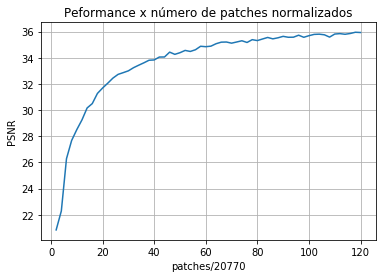

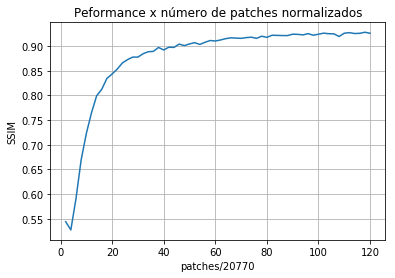

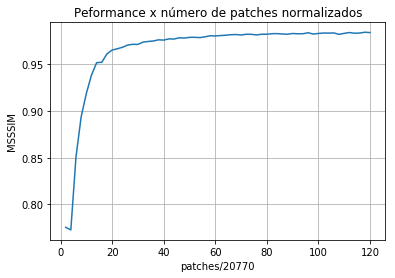

In [3]:
x=range(2,121,2)
print_graph(psnr,x,yl='PSNR')
print_graph(ssim,x,yl='SSIM')
print_graph(msssim,x,yl='MSSSIM')


In [4]:

print(len(psnr))
print('PSNR')   
for p in psnr:
    print(str(p).replace('.',','))

print('SSIM')
for s in ssim:
    print(str(s).replace('.',','))

print('MSSSIM')
for m in msssim: 
    print(str(m).replace('.',','))


60
PSNR
20,846977122472783
22,29151543843017
26,28747532061157
27,681195431540733
28,51018070624093
29,25160884812201
30,164375583926372
30,498184945555042
31,27543099447721
31,688185289209233
32,0559280479025
32,44496022660214
32,73014315257879
32,862627420192034
33,001649322437714
33,241510319168185
33,431784686249486
33,61342470009841
33,81030487126352
33,83272357393105
34,05487261192111
34,05947074838799
34,42933472754465
34,26117476343923
34,386677039914545
34,560876321457755
34,48231622245112
34,612143595107185
34,87843873818135
34,84570339171893
34,8869118485216
35,07292792603042
35,191607248398455
35,20263491846584
35,115609200041995
35,20506904778419
35,29809038198608
35,16831821771351
35,38210506147581
35,312332989317234
35,433667942272336
35,55163054664654
35,44482154365269
35,52497852499931
35,636249511218956
35,56548768847564
35,57148763772466
35,723399082220766
35,563587596660305
35,68677359449988
35,78496395607583
35,80217384030633
35,75407817909449
35,57799142826816
35,

In [11]:
print(x)

range(1, 121, 2)


In [12]:
reconstruida='/home/marcelo/Documentos/rnn-conv-autoencoder/Resultados/resultados_overfiting/kodim'
original='/home/marcelo/Documentos/rnn-conv-autoencoder/imagens_teste/kodim'
interacoes=16
msssim=np.zeros((24,interacoes), dtype=np.float64)
ssim=np.zeros((24,interacoes), dtype=np.float64)
psnr=np.zeros((24,interacoes), dtype=np.float64)

for j in range (1,25):
    if j<10:  
        original_img= original+'0'+str(j)+'.bmp'
    else:
        original_img= original+str(j)+'.bmp'
                       
  
    for i in range(interacoes):
               
        if i<10:  
            reconstruida_img= reconstruida+str(j)+'0'+str(i)+'.bmp'
        else:
            reconstruida_img= reconstruida+str(j)+str(i)+'.bmp'
    
        psnr[j-1][i]=my_analysis.calc_metric(original_img,reconstruida_img,Metrics.PSNR) 
        msssim[j-1][i]=my_analysis.calc_metric(original_img,reconstruida_img,Metrics.MSSSIM)
        ssim[j-1][i]=my_analysis.calc_metric(original_img,reconstruida_img,Metrics.SSIM)
        
print('PSNR:')
for y in range(0,interacoes):
    ls=[]
    for x in range(0,24):
        ls.append(psnr[x][y])
    print(str(np.mean(ls)).replace('.',','))

        
print('SSIM:')
for y in range(interacoes):
    ls=[]
    for x in range(0,24):
        ls.append(ssim[x][y])
    print(str(np.mean(ls)).replace('.',','))
    
print('MSSSIM:')
for y in range(interacoes):
    ls=[]
    for x in range(0,24):
        ls.append(msssim[x][y])
    print(str(np.mean(ls)).replace('.',','))
        




PSNR:
23,650263924068287
25,923608922551576
27,26640990602853
28,25848389008873
29,056349310115888
29,832929372005264
30,51789861869298
31,08492939178606
31,63828392176768
32,15741080481175
32,59922755458152
33,02770475634538
33,3645076986079
33,63271315272202
33,880560913711996
34,108120042808544
SSIM:
0,6318460216430402
0,7163050084574868
0,7735889002758561
0,8136886940401009
0,8423817134759307
0,8659026018234105
0,8838348101437301
0,8970295743535742
0,9089723180558913
0,9184314796831305
0,9258243647167236
0,9325082498727588
0,9370442795374414
0,9404514314183507
0,9435677255321512
0,9462000334241694
MSSSIM:
0,8267055475942313
0,9071370052393398
0,9377474219575298
0,9517690892926187
0,9616821604511706
0,9694541903148819
0,9752415765181959
0,9782029137364634
0,9804724655150542
0,9829112685836833
0,9848178375209934
0,9866933260478531
0,9880728724624771
0,9889436550749053
0,9895472125453916
0,9902420194512227
